# SBB Data Visualization preparation

The target of this script is to prepare the data to be used in the visualization project

In [1]:
import pandas as pd
import os

## SBB GA/AG

We first get the dataset from [open data](https://data.sbb.ch/explore/dataset/generalabo-halbtax/information/) which we then will prepare for our visualization

In [2]:
ga_hf = pd.read_csv("opentransportdata_ga-ag_hta-adt-meta-prezzo_2012-2021-2.csv")
ga_hf

,Jahr_An_Anno,PLZ_NPA,GA_AG,GA_AG_flag,HTA_ADT_meta-prezzo,HTA_ADT_meta-prezzo_flag
0,2012,1000,72,NaN,976,NaN
1,2012,1003,744,NaN,3'195,NaN
2,2012,1004,1'919,NaN,8'167,NaN
3,2012,1005,860,NaN,4'021,NaN
4,2012,1006,1'279,NaN,5'366,NaN
...,...,...,...,...,...,...
31854,2021,9652,56,NaN,286,NaN
31855,2021,9655,12,1.0,107,NaN
31856,2021,9656,22,NaN,194,NaN
31857,2021,9657,33,NaN,246,NaN


We have to convert string to int

In [3]:
ga_hf["GA_AG"] = ga_hf["GA_AG"].str.replace("'", "").astype("int64")
ga_hf["HTA_ADT_meta-prezzo"] = ga_hf["HTA_ADT_meta-prezzo"].str.replace("'", "").astype("int64")

# Bevölkerungsdate

We will add the population data to be able to show the GA per 100 persons. The dataset is provided by the [Post](bevoelkerung_proplz.csv).

In [4]:
population = pd.read_csv("bevoelkerung_proplz.csv", delimiter=";")
population = population.groupby("PLZ").sum()

which we can add to the dataframe

In [5]:
ga_hf = ga_hf.merge(population, left_on="PLZ_NPA", right_on="PLZ")

In [6]:
ga_hf

,Jahr_An_Anno,PLZ_NPA,GA_AG,GA_AG_flag,HTA_ADT_meta-prezzo,HTA_ADT_meta-prezzo_flag,Anzahl
0,2012,1000,72,NaN,976,NaN,4581
1,2013,1000,72,NaN,955,NaN,4581
2,2014,1000,84,NaN,977,NaN,4581
3,2015,1000,73,NaN,970,NaN,4581
4,2016,1000,78,NaN,1078,NaN,4581
...,...,...,...,...,...,...,...
31759,2020,7747,7,1.0,11,2.0,85
31760,2021,7747,6,1.0,11,2.0,85
31761,2014,6549,0,NaN,11,2.0,1
31762,2015,6549,0,NaN,11,2.0,1


# Postleizahl

Problem is they only give use the PLZ but not the Gemeinde. We will get the translation from [the Post](https://swisspost.opendatasoft.com/explore/dataset/plz_verzeichnis_v2/table/?disjunctive.postleitzahl)

In [7]:
reader = pd.read_csv("plz_verzeichnis_v2.csv", iterator=True, chunksize=10000, delimiter=";")

plz_to_gemeinde = pd.DataFrame()
for chunk in reader:
    out = chunk[["POSTLEITZAHL", "BFSNR", "KANTON"]]
    plz_to_gemeinde = pd.concat([plz_to_gemeinde, out])

In [8]:
plz_to_gemeinde.head(10)

,POSTLEITZAHL,BFSNR,KANTON
0,1000,5586,VD
1,1000,5586,VD
2,1000,5586,VD
3,1000,5586,VD
4,1000,5586,VD
5,1000,5586,VD
6,1002,5586,VD
7,1004,5586,VD
8,1006,5586,VD
9,1007,5586,VD


which we can add to our GA/HF

In [9]:
ga_hf_gemeinde = ga_hf.merge(plz_to_gemeinde, left_on="PLZ_NPA", right_on="POSTLEITZAHL")
#ga_hf_gemeinde = ga_hf_gemeinde[["Jahr_An_Anno", "PLZ_NPA", "GA", "HF", "BFSNR", "ORTBEZ27"]]

In [10]:
ga_hf_gemeinde.head(5)

,Jahr_An_Anno,PLZ_NPA,GA_AG,GA_AG_flag,HTA_ADT_meta-prezzo,HTA_ADT_meta-prezzo_flag,Anzahl,POSTLEITZAHL,BFSNR,KANTON
0,2012,1000,72,NaN,976,NaN,4581,1000,5586,VD
1,2012,1000,72,NaN,976,NaN,4581,1000,5586,VD
2,2012,1000,72,NaN,976,NaN,4581,1000,5586,VD
3,2012,1000,72,NaN,976,NaN,4581,1000,5586,VD
4,2012,1000,72,NaN,976,NaN,4581,1000,5586,VD


Problem is we have multiple Gemeinde for one PLZ, when calculating for % however we don't have this problem...

# Stops

The main question we had to answer was if we could see any correlation between the number of AG/HF sold by cantons

In [11]:
reader = pd.read_csv("dienststellen-gemass-opentransportdataswiss.csv", iterator=True, chunksize=1000, delimiter=";")

stops = pd.DataFrame()
for chunk in reader:
    c = chunk[["bpuic", "bfs_nummer", "gemeindename", "is_haltestelle"]]
    stops = pd.concat([stops, c])

In [12]:
stops = stops[stops["is_haltestelle"] == 1].dropna().drop("is_haltestelle", axis=1).drop_duplicates()

In [13]:
stops["bfs_nummer"] = stops["bfs_nummer"].astype(int)
stops_per_gemeinde = stops.groupby("bfs_nummer").agg({"bpuic": "count", "gemeindename": "first"})
stops_per_gemeinde

,bpuic,gemeindename
bfs_nummer,,
1,6,Aeugst am Albis
2,14,Affoltern am Albis
3,8,Bonstetten
4,10,Hausen am Albis
5,3,Hedingen
...,...,...
7009,15,Gamprin
7010,12,Ruggell
7011,13,Schellenberg


In [14]:
ga_hf_gemeinde = ga_hf_gemeinde.merge(stops_per_gemeinde, left_on="BFSNR", right_on="bfs_nummer")
ga_hf_gemeinde = ga_hf_gemeinde.drop_duplicates()
ga_hf_gemeinde = ga_hf_gemeinde[["Jahr_An_Anno", "PLZ_NPA", "GA_AG", "HTA_ADT_meta-prezzo", "KANTON", "Anzahl", "BFSNR", "bpuic", "gemeindename"]]

# Create Kantonal Data

Will be used to display the number of Habitant which have GA SBB

In [15]:
import pandas as pd

In [16]:
data = '''AG	Aargau
AI	Appenzell Innerhoden
AR	Appenzell Ausserhoden
BE	Bern
BL	Basel-Landschaft
BS	Basel-Stadt
FR	Freiburg
GE	Genf
GL	Glarus
GR	Graubünden
JU	Jura
LU	Luzern
NE	Neuenburg
NW	Nidwalden
OW	Obwalden
SG	St. Gallen
SH	Schaffhausen
SO	Solothurn
SZ	Schwyz
TG	Thurgau
TI	Tessin
UR	Uri
VD	Waadt
VS	Wallis
ZG	Zug
ZH	Zürich'''
data = pd.DataFrame(data.split("\n"))[0].str.split('\t', 1, expand=True)
data.columns = ["KANTON", "NAME"]

In [17]:
ga_hf = ga_hf_gemeinde.merge(data, left_on="KANTON", right_on="KANTON")

In [18]:
ga_hf = ga_hf.drop_duplicates()
ga_hf

,Jahr_An_Anno,PLZ_NPA,GA_AG,HTA_ADT_meta-prezzo,KANTON,Anzahl,BFSNR,bpuic,gemeindename,NAME
0,2012,1000,72,976,VD,4581,5586,218,Lausanne,Waadt
1,2013,1000,72,955,VD,4581,5586,218,Lausanne,Waadt
2,2014,1000,84,977,VD,4581,5586,218,Lausanne,Waadt
3,2015,1000,73,970,VD,4581,5586,218,Lausanne,Waadt
4,2016,1000,78,1078,VD,4581,5586,218,Lausanne,Waadt
...,...,...,...,...,...,...,...,...,...,...
33759,2017,9442,93,969,AI,5219,3111,16,Oberegg,Appenzell Innerhoden
33760,2018,9442,87,1002,AI,5219,3111,16,Oberegg,Appenzell Innerhoden
33761,2019,9442,79,1058,AI,5219,3111,16,Oberegg,Appenzell Innerhoden
33762,2020,9442,71,1029,AI,5219,3111,16,Oberegg,Appenzell Innerhoden


# Output the data

In [49]:
out = ga_hf[ga_hf["Jahr_An_Anno"] == 2021]
out = out.groupby("BFSNR").agg({
    "Jahr_An_Anno": "first",
    "PLZ_NPA": "first",
    "GA_AG": sum,
    "HTA_ADT_meta-prezzo": sum,
    "KANTON": "first",
    "Anzahl": sum,
    "bpuic": sum,
    "gemeindename": "first"
})

In [51]:
out["GA_pro_stop"] = out["GA_AG"].div(out["bpuic"])
out["HF_pro_stop"] = out["HTA_ADT_meta-prezzo"].div(out["bpuic"])

In [52]:
out["GA_pro_100"] = 100 * out["GA_AG"].div(out["Anzahl"])
out["HF_pro_100"] = 100 * out["HTA_ADT_meta-prezzo"].div(out["Anzahl"])

## Map plot

In [53]:
out[["GA_AG", "HTA_ADT_meta-prezzo", "Anzahl", "bpuic", "GA_pro_100", "HF_pro_100", "GA_pro_stop", "HF_pro_stop", "gemeindename"]].to_csv("GA_HF_pro_gemeinde.csv")

## Kanton Bar Plot

In [52]:
out = ga_hf[ga_hf["Jahr_An_Anno"] == 2021].groupby("KANTON").sum()
out["GA_pro_100"] = 100 * out["GA_AG"] / out["Anzahl"]
out["HF_pro_100"] = 100 * out["HTA_ADT_meta-prezzo"] / out["Anzahl"]
out = out[["GA_AG", "HTA_ADT_meta-prezzo", "GA_pro_100", "HF_pro_100"]]
out

,GA_AG,HTA_ADT_meta-prezzo,GA_pro_100,HF_pro_100
KANTON,,,,
AG,43228,219414,4.815723,24.443348
AI,935,12943,1.649437,22.832798
AR,1994,19028,2.726465,26.017639
BE,94017,456475,6.135050,29.787133
BL,8125,84073,2.151566,22.263209
BS,8815,70894,3.233830,26.007843
FR,15424,81812,3.116148,16.528679
GE,6093,94041,0.794259,12.258809
GL,1935,11320,3.545709,20.742858


<AxesSubplot:xlabel='KANTON'>

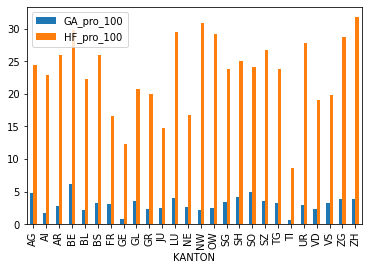

In [57]:
out.to_csv("GA_pro_Kanton.csv")
out[["GA_pro_100", "HF_pro_100"]].plot(kind="bar")

## Kanton Time Plot

In [ ]:
out = ga_hf.groupby(["KANTON", "Jahr_An_Anno"]).sum()
out["GA_pro_100"] = 100 * out["GA_AG"] / out["Anzahl"]
out["HF_pro_100"] = 100 * out["HTA_ADT_meta-prezzo"] / out["Anzahl"]

In [ ]:
out["GA_pro_100"].unstack().T.plot(color="red", alpha=0.7, figsize=(20, 10))

In [ ]:
out["HF_pro_100"].unstack().T.plot(color="grey", alpha=0.5, figsize=(20, 10))

# Anzahl Züge

In [63]:
path = "/Users/timoblattner/Documents/uniBe/Semester6/OpenData/Projekt/Data/202202-halte.csv"
reader = pd.read_csv(path, iterator=True, chunksize=10000, delimiter=",")

halte = pd.DataFrame()
for i, chunk in enumerate(reader):
    c = chunk[["TU_CODE", "BPUIC", "KANTON", "FARTNUMMER"]]
    halte = pd.concat([halte, c])

In [67]:
halte

,TU_CODE,BPUIC,KANTON,FARTNUMMER
0,101,8504351,BE,23000
1,101,8504350,BE,23000
2,101,8504352,BE,23000
3,101,8504351,BE,23001
4,101,8504350,BE,23001
...,...,...,...,...
4584247,9999,8509195,GR,906
4584248,9999,8509251,GR,906
4584249,9999,8509253,GR,906
4584250,9999,8509189,GR,906


In [58]:
bpuic = halte.groupby("BPUIC").agg({"KANTON": "first", "FAHRTAGE": "count"})

In [ ]:
bpuic.groupby("KANTON").count()/60.plot(kind="barh", figsize=(10, 20))